In [1]:
import pandas as pd


import os

import sys
sys.path.append('../')

import torch.nn as nn
import torch

from dataloader.dataloader import *
from training.training import *
from models.rae import *
from utils.utils import *
from visualizations.visualizations import *
from evaluation.evaluation import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

CUDA is available. Training on GPU.


In [3]:
data_folder = "../Data/Data v5"
df = pd.read_csv(os.path.join(data_folder, "amari_ue_data_final_v5_smoothed_scaled.csv"))
df = df.sort_values(["imeisv", "_time"], ascending = True)
df['imeisv'] = df['imeisv'].astype(str)

/tmp/ipykernel_190443/1554114771.py:2: DtypeWarning: Columns (16,24,26,27,32,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_folder, "amari_ue_data_final_v5_smoothed_scaled.csv"))


In [4]:
feature_columns = [
    'dl_bitrate','ul_bitrate', 
    'cell_x_dl_retx', 'cell_x_dl_tx',
    'cell_x_ul_retx', 'cell_x_ul_tx',
    'ul_total_bytes_non_incr', 'dl_total_bytes_non_incr'
]

# feature_columns = [
#     'dl_bitrate','ul_bitrate','ul_total_bytes_non_incr', 'dl_total_bytes_non_incr'
# ]

# feature_columns = [
#     'ul_bitrate'
# ]

In [5]:
benign_data_starting_point = "2024-03-20 14:14:50.19"
benign_data_ending_point = "2024-03-23 16:26:19.00"


benign_filter_1 = (df['_time'].between(benign_data_starting_point, benign_data_ending_point))
benign_filter_2 = (~df['imeisv'].isin(['8642840401594200', '8642840401612300','8642840401624200','3557821101183501']))
benign_filter_3 = (df['label'] == 0)
benign_data_filter = (benign_filter_1 & benign_filter_2 & benign_filter_3)

In [6]:
# benign data
benign_data_train = df[benign_data_filter].copy()
benign_data_train = benign_data_train.sort_values(['imeisv','_time'])
print(benign_data_train.shape[0])

260051


In [7]:
benign_data_test_period_start = "2024-03-24 01:20:00.19"
benign_devices_for_testing = ['8609960468879057', '8628490433231157','8677660403123800']

benign_filter_4 = (df['_time'] >= benign_data_test_period_start)
benign_filter_5 = (df['imeisv'].isin(benign_devices_for_testing))
benign_data_filter_test = (benign_filter_3 & benign_filter_4 & benign_filter_5)

benign_data_test = df[benign_data_filter_test].copy()
benign_data_test = benign_data_test.sort_values(['imeisv','_time'])
print(benign_data_test.shape[0])

90102


In [8]:
#malicious data
attck_1_start = "2024-03-23 21:26:00"
attck_1_end = "2024-03-23 22:23:00"
ues_to_exclude_in_1st_attck = [
    '8628490433231157','8609960480666910',
    '3557821101183501'] #'8677660403123800' '8642840401594200'

attck_2_start = "2024-03-23 22:56:00"
attck_2_end = "2024-03-23 23:56:00"
ues_to_exclude_in_2nd_attck = [
    '8609960480666910','8642840401612300'
]

mal_filter_1 = (
    df['_time'].between(attck_1_start, attck_1_end)
    & (~df['imeisv'].isin(ues_to_exclude_in_1st_attck))
)

mal_filter_2 = (
    df['_time'].between(attck_2_start, attck_2_end)
    & (~df['imeisv'].isin(ues_to_exclude_in_2nd_attck))
)

mal_filter_3 = (df['label'] == 1)

malicious_data = df[(mal_filter_1 | mal_filter_2) & mal_filter_3].copy()
malicious_data = malicious_data.sort_values(['imeisv','_time'])
print(malicious_data.shape[0])

10971


In [9]:
params = {'parameters': {'window_size': 120,
  'step_size': 40,
  'batch_size': 32,
  'hidden_dim1': 50,
  'hidden_dim2': 100,
  'dropout': 0.2,
  'layer_norm_flag': False,
  'loss_function': 'L1Loss',
  'lr': 0.001,
  'num_epochs': 52},
 'min_train_loss': 0.2222,
 'min_val_loss': 0.348,
 'min_train_val_gap': 0.1235,
 'epochs_trained': 44,
 'results_file': '../results/5bfa52f8-e8c6-4899-963d-3ebd80be60f9_history.pkl',
 'timestamp': '2024-04-16 00:52:07.473140',
 'rolling_avg': False,
 'feature_columns': ['ul_bitrate'],
 'dataset_used': 'no_outliers_scaled'}

In [10]:
train_data_loader, val_data_loader, mal_data_loader = create_ds_loader(
                benign_data_train, 
                malicious_data, 
                params['parameters']['window_size'], 
                params['parameters']['step_size'], 
                feature_columns, 
                params['parameters']['batch_size']
            )

## Recurrent Autoencoder

In [11]:
rae_model = LSTMAutoencoder(
    input_dim = len(feature_columns), 
    hidden_dim1 = params['parameters']['hidden_dim1'], 
    hidden_dim2 = params['parameters']['hidden_dim2'], 
    output_dim = len(feature_columns), 
    dropout = params['parameters']['dropout'], 
    layer_norm_flag = params['parameters']['layer_norm_flag']
)

rae_model.to(device)

early_stopping = EarlyStopping(patience=7, min_delta=0.)
criterion = nn.L1Loss()


In [12]:
history = rae_model.train_model(
    num_epochs = 64, 
    early_stopping = None, 
    train_data_loader = train_data_loader, 
    val_data_loader = val_data_loader, 
    mal_data_loader = mal_data_loader, 
    device = device, 
    criterion = criterion,  
    lr = 0.001
)

Validating...: 100%|██████████| 41/41 [00:00<00:00, 545.04it/s]


Epoch 1, Train Loss: 0.4636, Val Loss: 0.5072


Validating...: 100%|██████████| 41/41 [00:00<00:00, 543.51it/s]


Epoch 2, Train Loss: 0.4433, Val Loss: 0.5094


Validating...: 100%|██████████| 41/41 [00:00<00:00, 542.28it/s]


Epoch 3, Train Loss: 0.4374, Val Loss: 0.4921


Validating...: 100%|██████████| 41/41 [00:00<00:00, 539.88it/s]


Epoch 4, Train Loss: 0.3720, Val Loss: 0.3753


Validating...: 100%|██████████| 41/41 [00:00<00:00, 539.82it/s]


Epoch 5, Train Loss: 0.3075, Val Loss: 0.3524


Validating...: 100%|██████████| 41/41 [00:00<00:00, 540.40it/s]


Epoch 6, Train Loss: 0.2791, Val Loss: 0.3120


Validating...: 100%|██████████| 41/41 [00:00<00:00, 541.01it/s]


Epoch 7, Train Loss: 0.2456, Val Loss: 0.2782


Validating...: 100%|██████████| 41/41 [00:00<00:00, 539.47it/s]


Epoch 8, Train Loss: 0.2237, Val Loss: 0.2573


Validating...: 100%|██████████| 41/41 [00:00<00:00, 540.47it/s]


Epoch 9, Train Loss: 0.2123, Val Loss: 0.2499


Validating...: 100%|██████████| 41/41 [00:00<00:00, 538.49it/s]


Epoch 10, Train Loss: 0.2030, Val Loss: 0.2374


Validating...: 100%|██████████| 41/41 [00:00<00:00, 535.76it/s]


Epoch 11, Train Loss: 0.1961, Val Loss: 0.2320


Validating...: 100%|██████████| 41/41 [00:00<00:00, 534.11it/s]


Epoch 12, Train Loss: 0.1922, Val Loss: 0.2261


Validating...: 100%|██████████| 41/41 [00:00<00:00, 537.21it/s]


Epoch 13, Train Loss: 0.1885, Val Loss: 0.2248


Validating...: 100%|██████████| 41/41 [00:00<00:00, 531.07it/s]


Epoch 14, Train Loss: 0.1862, Val Loss: 0.2206


Validating...: 100%|██████████| 41/41 [00:00<00:00, 534.57it/s]


Epoch 15, Train Loss: 0.1846, Val Loss: 0.2173


Validating...: 100%|██████████| 41/41 [00:00<00:00, 534.68it/s]


Epoch 16, Train Loss: 0.1828, Val Loss: 0.2158


Validating...: 100%|██████████| 41/41 [00:00<00:00, 533.08it/s]


Epoch 17, Train Loss: 0.1791, Val Loss: 0.2202


Validating...: 100%|██████████| 41/41 [00:00<00:00, 536.19it/s]


Epoch 18, Train Loss: 0.1742, Val Loss: 0.2062


Validating...: 100%|██████████| 41/41 [00:00<00:00, 538.09it/s]


Epoch 19, Train Loss: 0.1636, Val Loss: 0.1962


Validating...: 100%|██████████| 41/41 [00:00<00:00, 538.71it/s]


Epoch 20, Train Loss: 0.1567, Val Loss: 0.1925


Validating...: 100%|██████████| 41/41 [00:00<00:00, 535.33it/s]


Epoch 21, Train Loss: 0.1511, Val Loss: 0.1847


Validating...: 100%|██████████| 41/41 [00:00<00:00, 538.81it/s]


Epoch 22, Train Loss: 0.1470, Val Loss: 0.1779


Validating...: 100%|██████████| 41/41 [00:00<00:00, 538.11it/s]


Epoch 23, Train Loss: 0.1434, Val Loss: 0.1746


Validating...: 100%|██████████| 41/41 [00:00<00:00, 537.71it/s]


Epoch 24, Train Loss: 0.1402, Val Loss: 0.1712


Validating...: 100%|██████████| 41/41 [00:00<00:00, 538.82it/s]


Epoch 25, Train Loss: 0.1383, Val Loss: 0.1704


Validating...: 100%|██████████| 41/41 [00:00<00:00, 539.24it/s]


Epoch 26, Train Loss: 0.1371, Val Loss: 0.1657


Validating...: 100%|██████████| 41/41 [00:00<00:00, 536.50it/s]


Epoch 27, Train Loss: 0.1337, Val Loss: 0.1631


Validating...: 100%|██████████| 41/41 [00:00<00:00, 533.14it/s]


Epoch 28, Train Loss: 0.1329, Val Loss: 0.1620


Validating...: 100%|██████████| 41/41 [00:00<00:00, 529.72it/s]


Epoch 29, Train Loss: 0.1315, Val Loss: 0.1604


Validating...: 100%|██████████| 41/41 [00:00<00:00, 534.94it/s]


Epoch 30, Train Loss: 0.1297, Val Loss: 0.1617


Validating...: 100%|██████████| 41/41 [00:00<00:00, 514.86it/s]


Epoch 31, Train Loss: 0.1295, Val Loss: 0.1577


Validating...: 100%|██████████| 41/41 [00:00<00:00, 536.49it/s]


Epoch 32, Train Loss: 0.1278, Val Loss: 0.1559


Validating...: 100%|██████████| 41/41 [00:00<00:00, 538.95it/s]


Epoch 33, Train Loss: 0.1266, Val Loss: 0.1566


Validating...: 100%|██████████| 41/41 [00:00<00:00, 527.93it/s]


Epoch 34, Train Loss: 0.1256, Val Loss: 0.1561


Validating...: 100%|██████████| 41/41 [00:00<00:00, 532.53it/s]


Epoch 35, Train Loss: 0.1261, Val Loss: 0.1538


Validating...: 100%|██████████| 41/41 [00:00<00:00, 535.17it/s]


Epoch 36, Train Loss: 0.1240, Val Loss: 0.1556


Validating...: 100%|██████████| 41/41 [00:00<00:00, 535.76it/s]


Epoch 37, Train Loss: 0.1232, Val Loss: 0.1534


Validating...: 100%|██████████| 41/41 [00:00<00:00, 532.37it/s]


Epoch 38, Train Loss: 0.1227, Val Loss: 0.1530


Validating...: 100%|██████████| 41/41 [00:00<00:00, 532.59it/s]


Epoch 39, Train Loss: 0.1220, Val Loss: 0.1500


Validating...: 100%|██████████| 41/41 [00:00<00:00, 519.22it/s]


Epoch 40, Train Loss: 0.1205, Val Loss: 0.1522


Validating...: 100%|██████████| 41/41 [00:00<00:00, 537.86it/s]


Epoch 41, Train Loss: 0.1197, Val Loss: 0.1471


Validating...: 100%|██████████| 41/41 [00:00<00:00, 537.96it/s]


Epoch 42, Train Loss: 0.1188, Val Loss: 0.1458


Validating...: 100%|██████████| 41/41 [00:00<00:00, 538.55it/s]


Epoch 43, Train Loss: 0.1183, Val Loss: 0.1484


Validating...: 100%|██████████| 41/41 [00:00<00:00, 529.03it/s]


Epoch 44, Train Loss: 0.1176, Val Loss: 0.1456


Validating...: 100%|██████████| 41/41 [00:00<00:00, 531.03it/s]


Epoch 45, Train Loss: 0.1171, Val Loss: 0.1443


Validating...: 100%|██████████| 41/41 [00:00<00:00, 531.32it/s]


Epoch 46, Train Loss: 0.1164, Val Loss: 0.1445


Validating...: 100%|██████████| 41/41 [00:00<00:00, 534.26it/s]


Epoch 47, Train Loss: 0.1156, Val Loss: 0.1410


Validating...: 100%|██████████| 41/41 [00:00<00:00, 535.64it/s]


Epoch 48, Train Loss: 0.1150, Val Loss: 0.1399


Validating...: 100%|██████████| 41/41 [00:00<00:00, 536.25it/s]


Epoch 49, Train Loss: 0.1156, Val Loss: 0.1410


Validating...: 100%|██████████| 41/41 [00:00<00:00, 536.10it/s]


Epoch 50, Train Loss: 0.1138, Val Loss: 0.1387


Validating...: 100%|██████████| 41/41 [00:00<00:00, 537.24it/s]


Epoch 51, Train Loss: 0.1129, Val Loss: 0.1378


Validating...: 100%|██████████| 41/41 [00:00<00:00, 534.89it/s]


Epoch 52, Train Loss: 0.1125, Val Loss: 0.1362


Validating...: 100%|██████████| 41/41 [00:00<00:00, 535.65it/s]


Epoch 53, Train Loss: 0.1122, Val Loss: 0.1360


Validating...: 100%|██████████| 41/41 [00:00<00:00, 537.67it/s]


Epoch 54, Train Loss: 0.1120, Val Loss: 0.1362


Validating...: 100%|██████████| 41/41 [00:00<00:00, 538.69it/s]


Epoch 55, Train Loss: 0.1111, Val Loss: 0.1347


Validating...: 100%|██████████| 41/41 [00:00<00:00, 529.33it/s]


Epoch 56, Train Loss: 0.1109, Val Loss: 0.1357


Validating...: 100%|██████████| 41/41 [00:00<00:00, 529.30it/s]


Epoch 57, Train Loss: 0.1104, Val Loss: 0.1332


Validating...: 100%|██████████| 41/41 [00:00<00:00, 532.32it/s]


Epoch 58, Train Loss: 0.1102, Val Loss: 0.1326


Validating...: 100%|██████████| 41/41 [00:00<00:00, 529.28it/s]


Epoch 59, Train Loss: 0.1094, Val Loss: 0.1326


Validating...: 100%|██████████| 41/41 [00:00<00:00, 531.02it/s]


Epoch 60, Train Loss: 0.1089, Val Loss: 0.1334


Validating...: 100%|██████████| 41/41 [00:00<00:00, 530.61it/s]


Epoch 61, Train Loss: 0.1090, Val Loss: 0.1313


Validating...: 100%|██████████| 41/41 [00:00<00:00, 531.98it/s]


Epoch 62, Train Loss: 0.1083, Val Loss: 0.1302


Validating...: 100%|██████████| 41/41 [00:00<00:00, 530.86it/s]


Epoch 63, Train Loss: 0.1082, Val Loss: 0.1327


Validating...: 100%|██████████| 41/41 [00:00<00:00, 530.14it/s]

Epoch 64, Train Loss: 0.1079, Val Loss: 0.1269


In [13]:
#history.val_losses[13:20]

In [14]:
#history.val_losses[14] = 0.6

In [15]:
#history.val_losses[27] = 0.52

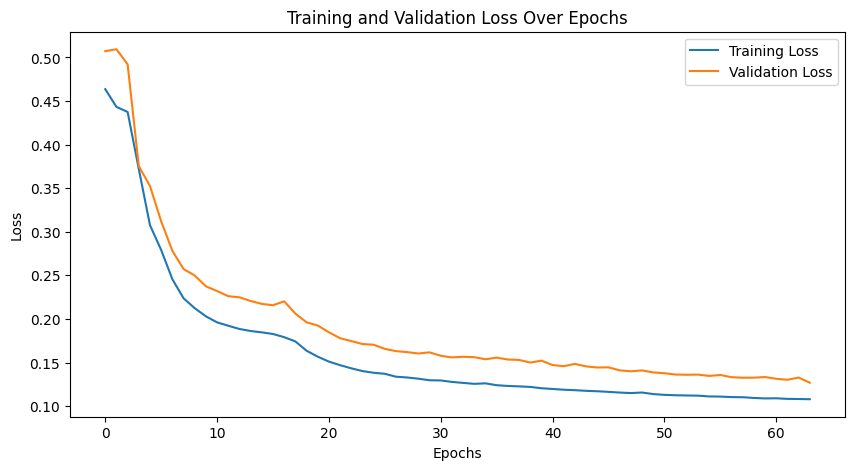

In [16]:
plot_train_val_loss(history.train_losses, history.val_losses)

In [33]:
test_batch_size = 1
benign_test_data_loader, mal_test_data_loader = create_test_ds_loaders(
    benign_data_test, 
    malicious_data, 
    120, 
    10, 
    features = feature_columns, 
    batch_size = test_batch_size
)

In [34]:
benign_test_losses, mal_test_losses = evaluate(rae_model, criterion, benign_test_data_loader, mal_test_data_loader, device)
#benign_test_losses, mal_test_losses = evaluate(rae_model, criterion, val_data_loader, mal_data_loader, device)

Validating...: 100%|██████████| 948/948 [00:01<00:00, 834.76it/s]


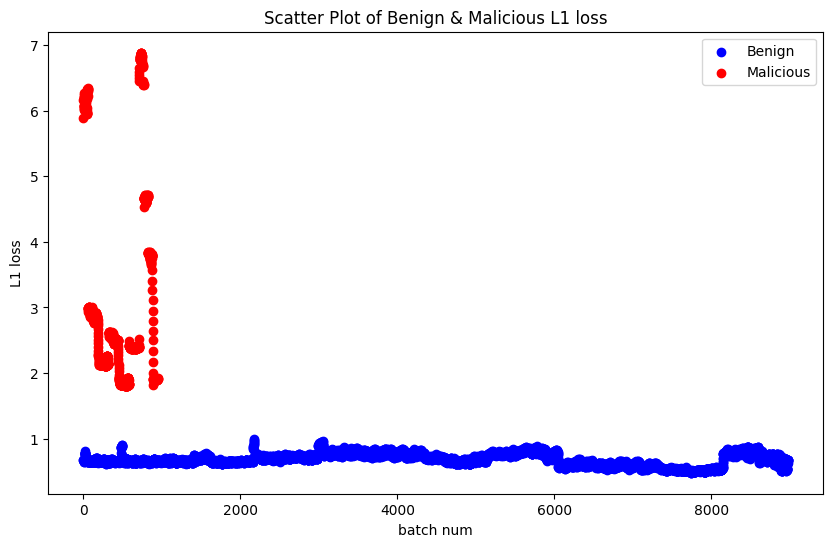

In [35]:
plot_scatter_plot_rec_loss(benign_test_losses, mal_test_losses)

In [36]:
fpr, tpr, thresholds, roc_auc, optimal_threshold = calculate_threshold(benign_test_losses, mal_test_losses)

In [37]:
plot_roc_curve(fpr, tpr, thresholds , roc_auc)

In [38]:
optimal_threshold

1.7947005033493042

In [39]:
accuracy, precision, recall, f1, tp_rate, tn_rate, fp_rate, fn_rate = infer(benign_test_losses, mal_test_losses, optimal_threshold)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
True Positives (TP): 948 (100.00%)
True Negatives (TN): 8975 (100.00%)
False Positives (FP): 0 (0.00%)
False Negatives (FN): 0 (0.00%)
